In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import datetime

In [2]:
spark = SparkSession.builder \
    .appName("assignment_1") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-01-25 09:38:27,317 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file_path_tracks = "hdfs://localhost:9000/datasets/spotify/tracks.json"
tracks_df = spark.read.format("json").load(file_path_tracks)
file_path_playlist = "hdfs://localhost:9000/datasets/spotify/playlist.json"
playlist_df = spark.read.format("json").load(file_path_playlist)


## Task1: Statistics about songs duration

In [4]:
original_count = tracks_df.count()
original_count

10760544

### 1.Generate a table containing the minimum, average and maximum duration, in milliseconds, of the songs in the dataset.

In [5]:
duration_stats = tracks_df.agg(
    F.min("duration_ms").alias("min_duration"),
    F.avg("duration_ms").alias("avg_duration"),
    F.max("duration_ms").alias("max_duration")
)
duration_stats.show()

+------------+------------------+------------+
|min_duration|      avg_duration|max_duration|
+------------+------------------+------------+
|           0|234408.54976216817|    10435467|
+------------+------------------+------------+



### 2. Compute the first and third quartiles (denoted $Q_1$ and $Q_3$), as well as the interquartile range (IQR) ($Q_3 - Q_1$)

In [6]:
quantiles = tracks_df.approxQuantile("duration_ms", [0.25, 0.75], 0.0)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1
print(f"q1: {q1}")
print(f"q3: {q3}")
print(f"iqr: {iqr}")

q1: 198333.0
q3: 258834.0
iqr: 60501.0


### 3. Compute the set of songs with durations that are not outliers

As defined by the IQRR methodology, identify all songs with duration $x$ such that $Q_1 - 1.5\times \text{IQR} < x < Q_3 + 1.5 \times IQR  $

In [7]:
filtered_df = tracks_df.filter((tracks_df["duration_ms"] >= q1 - 1.5 * iqr) & (tracks_df["duration_ms"] <= q3 + 1.5 * iqr))

### 4. Using the IQRR methodology, how many songs would be considered outliers and removed from analysis? Generate a new table containing the minimum, average and maximum duration of the remaining songs

New table containing the minimum, average and maximum duration of the remaining songs

In [8]:
remaining_stats = filtered_df.agg(
    F.min("duration_ms").alias("min_duration"),
    F.avg("duration_ms").alias("avg_duration"),
    F.max("duration_ms").alias("max_duration")
)
remaining_stats.show()

+------------+------------------+------------+
|min_duration|      avg_duration|max_duration|
+------------+------------------+------------+
|      107582|226899.35353939075|      349583|
+------------+------------------+------------+



How many songs would be considered outliers and removed from analysis?

In [9]:
remaining_count = filtered_df.count()
removed_count = original_count - remaining_count
removed_count

559989

## Task2: Finding the most popular artists over time

In [10]:
joint_df = tracks_df.join(playlist_df, tracks_df.pid == playlist_df.pid).drop(playlist_df.pid)

In [11]:
artist_popularity = (
    joint_df.groupBy("artist_name")
    .agg(F.countDistinct("pid").alias("playlist_count"))
    .orderBy(F.desc("playlist_count"))
    .limit(5)
)

In [12]:
artist_popularity.show()

+--------------+--------------+
|   artist_name|playlist_count|
+--------------+--------------+
|         Drake|         32259|
|       Rihanna|         23963|
|    Kanye West|         22464|
|    The Weeknd|         20046|
|Kendrick Lamar|         19159|
+--------------+--------------+



In [13]:
top_artists = artist_popularity.orderBy("artist_name").select("artist_name").rdd.flatMap(lambda x: x).collect()
top_artists

['Drake', 'Kanye West', 'Kendrick Lamar', 'Rihanna', 'The Weeknd']

In [14]:
modified_at_list = (
    joint_df.filter(F.col("artist_name").isin(top_artists))
    .groupBy("artist_name")
    .agg(F.sort_array(F.collect_list("modified_at")).alias("sorted_modified_at"))
    .orderBy("artist_name")
    .select("sorted_modified_at")
    .rdd.flatMap(lambda x: x)
    .collect()
)

In [15]:
min_date = min([min(sub_list) for sub_list in modified_at_list])
max_date = max([max(sub_list) for sub_list in modified_at_list])
min_date, max_date

(1305244800, 1509494400)

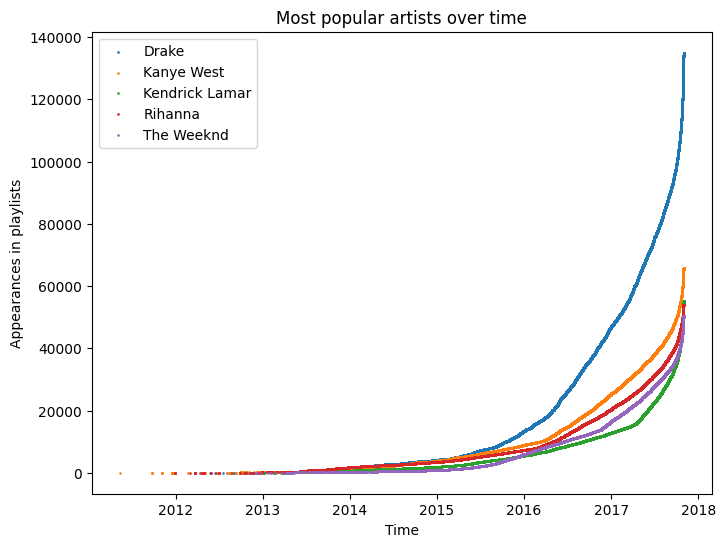

In [16]:
y = [list(range(1, 1 + len(sub_list))) for sub_list in modified_at_list]

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(5):
    converted_dates = [datetime.datetime.fromtimestamp(timestamp) for timestamp in modified_at_list[i]]
    ax.scatter(converted_dates, y[i], label=top_artists[i], s=0.8)

ax.set_title("Most popular artists over time")
ax.set_xlabel("Time")
ax.set_ylabel("Appearances in playlists")
ax.legend()
fig.show()
fig.savefig("popular_artists_over_time.png", bbox_inches="tight")


## Task3: Playlists's behavior

In [17]:
def get_fraction(pid):
    selected_df = tracks_df.filter(F.col("pid")==pid)
    total_len = selected_df.count()
    grouped_df = selected_df.groupBy("artist_name").agg(F.count("artist_name").alias("count"))
    ordered_df = grouped_df.orderBy(F.col("count").desc())
    most_len = ordered_df.first()["count"]
    return most_len/total_len

In [18]:
total_songs_per_pid_df = tracks_df.groupBy("pid").agg(F.count("artist_name")).orderBy(F.col("pid"))
total_songs_per_pid_df.show()

+---+------------------+
|pid|count(artist_name)|
+---+------------------+
|  0|                52|
|  1|                39|
|  2|                64|
|  3|               126|
|  4|                17|
|  5|                80|
|  6|                16|
|  7|                53|
|  8|                46|
|  9|                21|
| 10|                72|
| 11|               134|
| 12|                 9|
| 13|                13|
| 14|               103|
| 15|                 7|
| 16|               105|
| 17|                79|
| 18|                68|
| 19|                85|
+---+------------------+
only showing top 20 rows



In [19]:
# apply window function to partition by pid
window = Window.partitionBy('pid').orderBy(F.desc('count'))
# in each window, `songs_count_rank` is ranking in terms songs count per playlist
windowed_by_pid = tracks_df.groupBy('pid', 'artist_name').count().withColumn('songs_count_rank', F.row_number().over(window))
windowed_by_pid.show()

+---+--------------------+-----+----------------+
|pid|         artist_name|count|songs_count_rank|
+---+--------------------+-----+----------------+
|  0|     Jesse McCartney|    4|               1|
|  0|       Justin Bieber|    3|               2|
|  0|         Chris Brown|    3|               3|
|  0|     Boys Like Girls|    2|               4|
|  0|       Avril Lavigne|    2|               5|
|  0|  The Pussycat Dolls|    2|               6|
|  0|             Beyoncé|    2|               7|
|  0|               Usher|    2|               8|
|  0|         Miley Cyrus|    2|               9|
|  0|     Destiny's Child|    2|              10|
|  0|               Ne-Yo|    2|              11|
|  0|              Cassie|    1|              12|
|  0|         Sheryl Crow|    1|              13|
|  0|      Jonas Brothers|    1|              14|
|  0|The All-American ...|    1|              15|
|  0|           blink-182|    1|              16|
|  0|   Justin Timberlake|    1|              17|


In [20]:
top_count_per_pid = windowed_by_pid.filter(F.col('songs_count_rank') == 1).drop('songs_count_rank').orderBy(F.col("pid"))
top_count_per_pid.show()

+---+--------------------+-----+
|pid|         artist_name|count|
+---+--------------------+-----+
|  0|     Jesse McCartney|    4|
|  1|                Rush|    7|
|  2|                 BTS|    8|
|  3|           Hüsker Dü|    5|
|  4|The Smashing Pump...|    2|
|  5|       Rascal Flatts|    6|
|  6|             Misfits|    3|
|  7|                HAIM|    2|
|  8|         The Beatles|    8|
|  9|       Merle Haggard|    2|
| 10|           Lil Wayne|    5|
| 11|           DJ Shadow|   10|
| 12|           Passenger|    1|
| 13|             Ruth B.|    2|
| 14|             Nirvana|    6|
| 15|         Sylvan Esso|    3|
| 16|The Airborne Toxi...|    4|
| 17|     Imagine Dragons|    5|
| 18|          Tim McGraw|    3|
| 19|          Nick Drake|    4|
+---+--------------------+-----+
only showing top 20 rows



In [21]:
max_counts = top_count_per_pid.select("count").rdd.flatMap(lambda x: x).collect()
total_counts = total_songs_per_pid_df.select("count(artist_name)").rdd.flatMap(lambda x: x).collect()

In [22]:
fractions =[m / t for m, t  in zip(max_counts, total_counts)]
fractions = sorted(fractions)
fractions[:15]

[0.005319148936170213,
 0.006024096385542169,
 0.006172839506172839,
 0.006211180124223602,
 0.006329113924050633,
 0.008658008658008658,
 0.008771929824561403,
 0.009389671361502348,
 0.009433962264150943,
 0.009523809523809525,
 0.009569377990430622,
 0.009708737864077669,
 0.00980392156862745,
 0.009900990099009901,
 0.01]

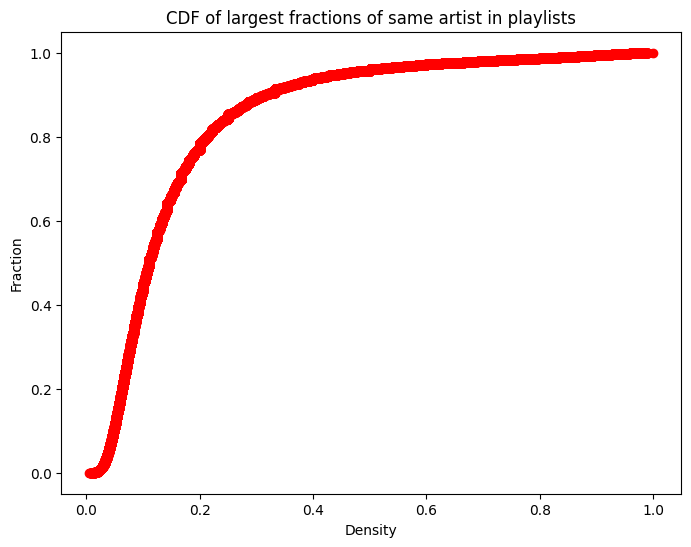

In [23]:
import numpy as np

num_points = len(fractions)
y = np.linspace(0, 1, num_points)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fractions, y, color="red", label="Data Points")
ax.set_title("CDF of largest fractions of same artist in playlists")
ax.set_xlabel("Density")
ax.set_ylabel("Fraction")
fig.show()
fig.savefig("cdf_prevalence_over_playlist.png", bbox_inches="tight")